# packages

In [1]:
import time
import investpy
# https://investpy.readthedocs.io/_info/introduction.html
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pyfolio as pf #https://quantopian.github.io/pyfolio/ - need to install from git because of dependencies errors
from alpha_vantage.timeseries import TimeSeries
import yfinance as yf #https://pypi.org/project/yfinance/#description
import edhec_risk_kit_129 as erk
import requests
from io import StringIO
from pprint import pprint
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
from collections import defaultdict

from utils import concat_top, calculate_dist

warnings.filterwarnings("ignore")

C:\Users\User\Anaconda3\envs\py37_trade\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


# load dataframes

In [2]:
df_admiral = pickle.load(open('data/df_admiral_yf.pickle', 'rb'))
df_finax = pickle.load(open('data/df_finax.pickle', 'rb'))

weird_admiral_etf_list = pickle.load(open('data/weird_admiral_etf_list.pickle', 'rb'))

#df_finax_stats = pickle.load(open('data/df_finax_stats.pickle', 'rb'))
df_admiral_stats = pickle.load(open('data/df_admiral_stats.pickle', 'rb'))

In [3]:
weird_admiral_etf_list.append('MTX1.PA')

df_admiral = df_admiral['Adj Close']
df_admiral = df_admiral.loc[:, ~df_admiral.columns.isin(weird_admiral_etf_list)]
df_finax = df_finax.tz_localize('UTC')
df_finax = df_finax['Adj Close']
df_admiral = df_admiral.tz_localize('UTC')

#df_admiral_stats = df_admiral_stats.loc[~df_admiral_stats.index.isin(weird_admiral_etf_list)]

# correlations

### all

In [4]:
df = df_finax.join(df_admiral, how = 'outer')
cm = sns.color_palette("coolwarm", as_cmap=True)
df_corr = df.corr()[df_finax.columns].iloc[10:,:]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_corr.style.background_gradient(cmap=cm, axis = None))

,DBZB.DE,FRCK.DE,IS3N.DE,SPY4.DE,SXR8.DE,XBLC.MI,XHYA.DE,XSX6.MI,XXSC.MI,ZPRR.DE
2INVE.MC,-0.791860,-0.669928,-0.894603,-0.797227,-0.778272,-0.836784,-0.803874,-0.894795,-0.872152,-0.865585
ACWI.PA,0.912920,0.728546,0.915571,0.982703,0.995142,0.957849,0.834353,0.962034,0.966382,0.931025
AEEM.PA,0.736315,0.765675,0.999456,0.897211,0.899051,0.810719,0.848618,0.871500,0.882992,0.913539
AGED.L,-0.795603,-0.189216,-0.353630,-0.234413,-0.617698,-0.509913,-0.176755,-0.162786,-0.179323,-0.249399
AUCO.AS,-0.331035,0.485893,0.581773,0.085151,-0.231954,-0.292611,0.447575,-0.423750,-0.386051,0.506944
AUT.PA,-0.313628,0.710967,0.807719,0.906475,0.541281,0.616415,0.853514,0.855868,0.862537,0.877940
BNK.PA,-0.161799,-0.077510,-0.199161,0.007830,-0.119571,-0.258299,-0.135044,0.077324,-0.081708,-0.223472
BNKE.PA,-0.811899,-0.043747,-0.224037,-0.449425,-0.635931,-0.596210,-0.124984,-0.253834,-0.316686,-0.249842
BRE.PA,0.262994,0.621920,0.935542,0.634452,0.385055,0.285092,0.782129,0.402094,0.319402,0.915472
BSX.PA,-0.926523,-0.751789,-0.902781,-0.940053,-0.918579,-0.964046,-0.875312,-0.971135,-0.955780,-0.899882


### max

In [5]:
df_corr_min = df_corr.apply(lambda x: x[x == x.max()])
display(df_corr_min.style.background_gradient(cmap=cm, axis = None))

,DBZB.DE,FRCK.DE,IS3N.DE,SPY4.DE,SXR8.DE,XBLC.MI,XHYA.DE,XSX6.MI,XXSC.MI,ZPRR.DE
AEEM.PA,nan,nan,0.999456,nan,nan,nan,nan,nan,nan,nan
CST.PA,nan,0.831271,nan,nan,nan,nan,nan,nan,nan,nan
ERO.PA,nan,nan,nan,nan,nan,nan,nan,0.999645,nan,nan
EXS3.DE,nan,nan,nan,nan,nan,nan,nan,nan,0.996017,nan
MAA.PA,0.993385,nan,nan,nan,nan,0.976584,nan,nan,nan,nan
PVX.PA,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.947049
USA.PA,nan,nan,nan,nan,0.997199,nan,nan,nan,nan,nan
WLD.PA,nan,nan,nan,0.985981,nan,nan,nan,nan,nan,nan
XSX6.L,nan,nan,nan,nan,nan,nan,0.931084,nan,nan,nan


# similarities of pyfolio stats

## euclidian distance matrix

### all

In [6]:
df_dist = calculate_dist(df_finax, df_admiral)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_dist.style.background_gradient(cmap=cm, axis = 'rows'))

,DBZB.DE,FRCK.DE,IS3N.DE,SPY4.DE,SXR8.DE,XBLC.MI,XHYA.DE,XSX6.MI,XXSC.MI,ZPRR.DE
2INVE.MC,7.977524,7.197969,6.977297,8.872052,9.285898,8.819351,6.712890,8.173715,7.901189,7.400115
ACWI.PA,3.376675,4.425667,2.359124,1.290215,1.572473,3.222805,3.531416,1.702931,1.129203,1.747822
AEEM.PA,2.946408,3.449554,0.462997,2.455150,3.540972,3.865708,2.999594,1.651489,2.508681,1.799439
AGED.L,11.426002,12.681618,13.356782,12.049450,12.789510,10.679626,13.600193,12.926838,12.454398,12.900514
AUCO.AS,6.320943,3.675110,3.249227,6.094502,6.114398,6.824514,3.856867,5.312664,5.304675,3.030982
AUT.PA,5.398987,4.248689,2.756138,1.754077,5.735760,3.860648,3.894002,5.722324,3.809018,2.875488
BNK.PA,5.916631,3.901912,4.469230,5.008102,5.538538,5.678695,4.915087,4.599470,4.946124,4.984123
BNKE.PA,4.828925,4.480750,4.631169,4.559316,5.492214,5.166390,5.249613,4.071877,4.660116,4.795078
BRE.PA,5.591667,5.852050,2.880822,4.272224,5.132346,5.584023,3.866810,4.170124,4.505873,2.999621
BSX.PA,7.367246,6.635214,6.052369,7.291804,6.761845,7.370333,6.248624,7.555669,5.409197,6.587097


### min

In [7]:
df_dist_min = df_dist.apply(lambda x: x[x == x.min()])
display(df_dist_min.style.background_gradient(cmap=cm, axis = None))

,DBZB.DE,FRCK.DE,IS3N.DE,SPY4.DE,SXR8.DE,XBLC.MI,XHYA.DE,XSX6.MI,XXSC.MI,ZPRR.DE
AEEM.PA,nan,nan,0.462997,nan,nan,nan,nan,nan,nan,nan
CST.PA,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.610884
DBXA.DE,nan,nan,nan,nan,nan,nan,nan,0.601821,nan,nan
DXSH.DE,nan,nan,nan,0.668444,nan,nan,nan,nan,nan,nan
EXS3.DE,nan,nan,nan,nan,nan,nan,nan,nan,0.634440,nan
MAA.PA,0.997318,nan,nan,nan,nan,2.051345,nan,nan,nan,nan
MVEU.SW,nan,nan,nan,nan,nan,nan,1.537222,nan,nan,nan
SLXX.L,nan,1.386743,nan,nan,nan,nan,nan,nan,nan,nan
VUSA.L,nan,nan,nan,nan,0.668803,nan,nan,nan,nan,nan


## weighted eucl. distance

In [8]:
df_admiral_stats.columns

Index(['Annual return', 'Cumulative returns', 'Annual volatility',
       'Sharpe ratio', 'Calmar ratio', 'Stability', 'Max drawdown',
       'Omega ratio', 'Sortino ratio', 'Skew', 'Kurtosis', 'Tail ratio',
       'Daily value at risk'],
      dtype='object')

In [9]:
weights = [7, 7, 10, 10, 1, 1 ,10, 1, 1, 5, 5, 1, 10]

### all

In [10]:
df_dist_w = calculate_dist(df_finax, df_admiral, weights)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_dist_w.style.background_gradient(cmap=cm, axis = 'rows'))

,DBZB.DE,FRCK.DE,IS3N.DE,SPY4.DE,SXR8.DE,XBLC.MI,XHYA.DE,XSX6.MI,XXSC.MI,ZPRR.DE
2INVE.MC,21.726974,19.963847,19.755691,24.388306,25.753537,23.968749,18.181807,23.276028,21.790620,20.238369
ACWI.PA,8.550935,8.824767,5.260819,3.742979,3.316484,8.477200,6.417340,3.698353,2.426925,4.542356
AEEM.PA,7.097706,8.011440,0.890989,5.813315,8.098752,8.730299,6.365194,2.933952,5.240767,4.151071
AGED.L,30.522437,33.943884,36.167745,32.782172,34.408699,28.354993,35.749346,34.359173,32.633385,34.580725
AUCO.AS,16.609084,11.368856,8.830037,14.803707,14.900706,16.477556,10.244364,12.830603,13.209220,7.833886
AUT.PA,12.574542,12.211642,7.700427,5.154283,10.256877,11.149187,11.696177,9.682022,7.672745,5.540436
BNK.PA,13.500421,10.654983,10.456409,10.243489,11.894273,13.715425,12.329971,9.597337,10.585651,11.027697
BNKE.PA,13.162867,12.789409,12.490098,11.676587,13.854038,13.801089,13.852402,11.273402,11.264058,12.419366
BRE.PA,14.171632,15.425146,8.182869,10.326330,11.839795,14.082598,10.806428,9.961318,9.920150,7.605218
BSX.PA,17.953936,14.351173,14.211754,17.409286,16.803184,17.906077,13.931473,18.170551,13.027785,15.393791


### min

In [11]:
df_dist_w_min = df_dist_w.apply(lambda x: x[x == x.min()])
display(df_dist_w_min.style.background_gradient(cmap=cm, axis = None))

,DBZB.DE,FRCK.DE,IS3N.DE,SPY4.DE,SXR8.DE,XBLC.MI,XHYA.DE,XSX6.MI,XXSC.MI,ZPRR.DE
DBX1.DE,nan,nan,0.776147,nan,nan,nan,nan,nan,nan,nan
DBXA.DE,nan,nan,nan,nan,nan,nan,nan,1.309907,nan,nan
DXSH.DE,nan,nan,nan,1.829187,nan,nan,nan,nan,nan,nan
DXSK.DE,nan,nan,nan,nan,nan,nan,3.706531,nan,nan,nan
IND.PA,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.309711
MAA.PA,1.884236,nan,nan,nan,nan,2.916467,nan,nan,nan,nan
SLXX.L,nan,2.104586,nan,nan,nan,nan,nan,nan,nan,nan
TNO.PA,nan,nan,nan,nan,nan,nan,nan,nan,1.384995,nan
VUSA.L,nan,nan,nan,nan,1.828504,nan,nan,nan,nan,nan


# regressions

# union etfs

In [12]:
set().union(*[list(df_corr_min.index), list(df_dist_min.index), list(df_dist_w_min.index)])

{'AEEM.PA',
 'CST.PA',
 'DBX1.DE',
 'DBXA.DE',
 'DXSH.DE',
 'DXSK.DE',
 'ERO.PA',
 'EXS3.DE',
 'IND.PA',
 'MAA.PA',
 'MVEU.SW',
 'PVX.PA',
 'SLXX.L',
 'TNO.PA',
 'USA.PA',
 'VUSA.L',
 'WLD.PA',
 'XSX6.L'}

# top n corr + eucl. distance + w

In [13]:
d = {'corr':{'dataframe':df_corr, 'topn':5, 'type':'largest'},
    'eucl_dist':{'dataframe':df_dist, 'topn':5, 'type':'smallest'},
    'eucl_dist_w':{'dataframe':df_dist_w, 'topn':5, 'type':'smallest'}}

In [14]:
df = concat_top(d)

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.style.background_gradient(cmap=cm, axis = 'rows'))

# top admiral etfs

In [16]:
dic = {'DBZB.DE':['MAA.PA', 'LQDA.L', 'FTAL.L'],
      'FRCK.DE':['SLXX.L', 'EUN1.DE', 'FOO.PA'],
      'IS3N.DE':['AEEM.PA', 'DBX1.DE', 'IJPE.L'],
      'SPY4.DE':['DXSH.DE', 'TNO.PA', 'WLD.PA'],
      'SXR8.DE':['XDWD.DE', 'LYPS.DE', 'USA.PA'],
      'XBLC.MI':['MAA.PA', 'LQDA.L', 'SLXX.L'],
      'XHYA.DE':['XSX6.L', 'DXSK.DE', 'MVEU.SW'],
      'XSX6.MI':['DBXA.DE', 'ERO.PA', 'FTAL.L'],
      'XXSC.MI':['EXS3.DE', 'TNO.PA', 'DXSH.DE'],
      'ZPRR.DE':['CST.PA', 'PVX.PA', 'IND.PA']}
df_top = pd.DataFrame.from_dict(dic, orient = 'columns')

In [17]:
df_top

,DBZB.DE,FRCK.DE,IS3N.DE,SPY4.DE,SXR8.DE,XBLC.MI,XHYA.DE,XSX6.MI,XXSC.MI,ZPRR.DE
0,MAA.PA,SLXX.L,AEEM.PA,DXSH.DE,XDWD.DE,MAA.PA,XSX6.L,DBXA.DE,EXS3.DE,CST.PA
1,LQDA.L,EUN1.DE,DBX1.DE,TNO.PA,LYPS.DE,LQDA.L,DXSK.DE,ERO.PA,TNO.PA,PVX.PA
2,FTAL.L,FOO.PA,IJPE.L,WLD.PA,USA.PA,SLXX.L,MVEU.SW,FTAL.L,DXSH.DE,IND.PA


In [18]:
set(np.concatenate(df_top.values))

{'AEEM.PA',
 'CST.PA',
 'DBX1.DE',
 'DBXA.DE',
 'DXSH.DE',
 'DXSK.DE',
 'ERO.PA',
 'EUN1.DE',
 'EXS3.DE',
 'FOO.PA',
 'FTAL.L',
 'IJPE.L',
 'IND.PA',
 'LQDA.L',
 'LYPS.DE',
 'MAA.PA',
 'MVEU.SW',
 'PVX.PA',
 'SLXX.L',
 'TNO.PA',
 'USA.PA',
 'WLD.PA',
 'XDWD.DE',
 'XSX6.L'}

## DBZB

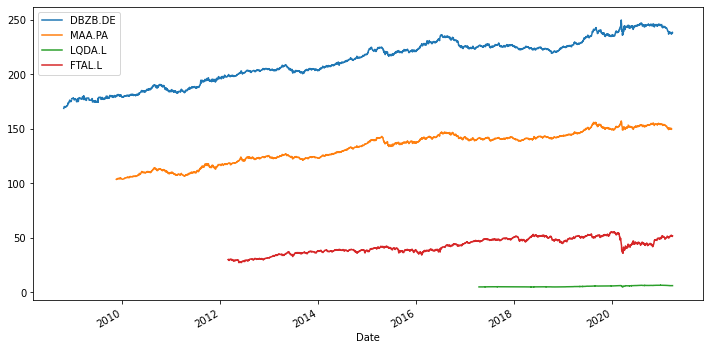

In [19]:
df = pd.DataFrame(df_finax['DBZB.DE'])
df = df.join(df_admiral[df_top['DBZB.DE']], how = 'outer')
df.plot(figsize = (12,6))

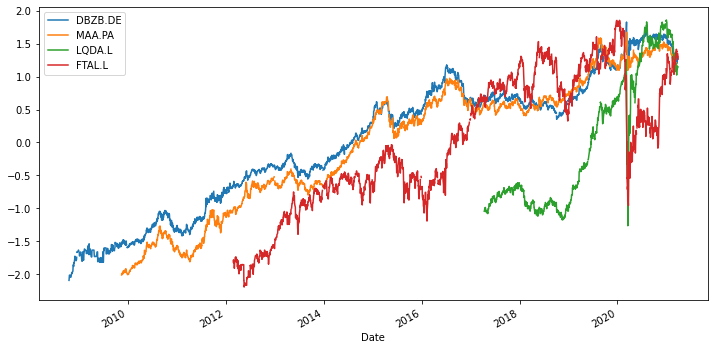

In [20]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns, index = df.index)
df.plot(figsize = (12,6)) # top 1 pick - MAA.PA

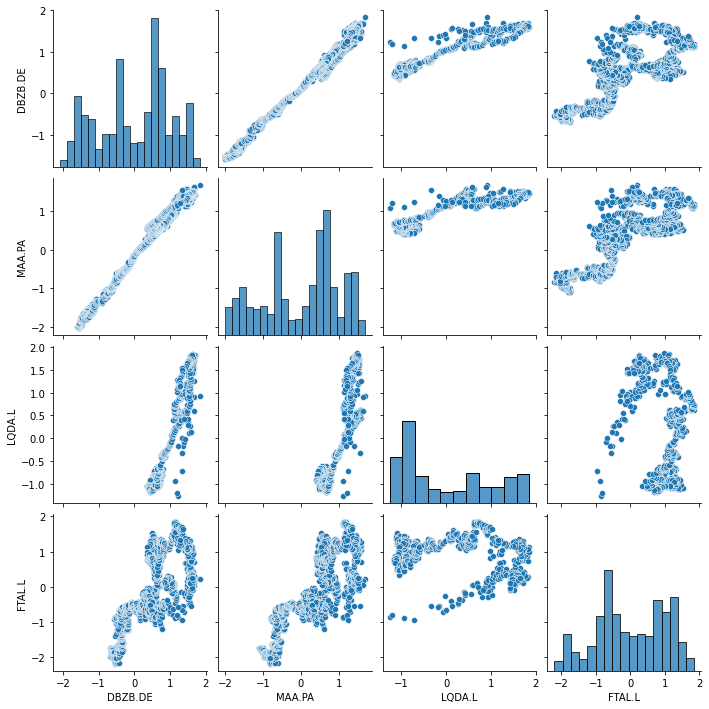

In [21]:
sns.pairplot(df)

## FRCK

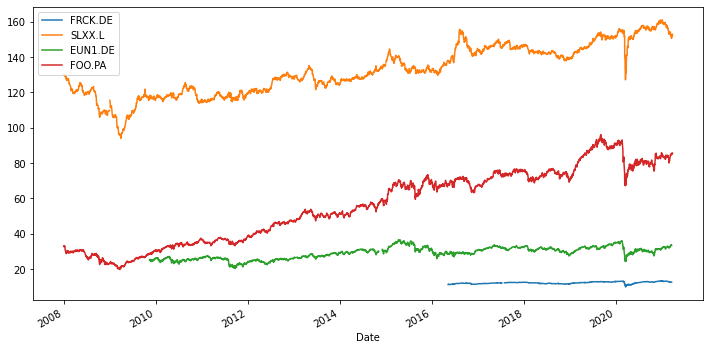

In [22]:
df = pd.DataFrame(df_finax['FRCK.DE'])
df = df.join(df_admiral[df_top['FRCK.DE']], how = 'outer')
df.plot(figsize = (12,6))

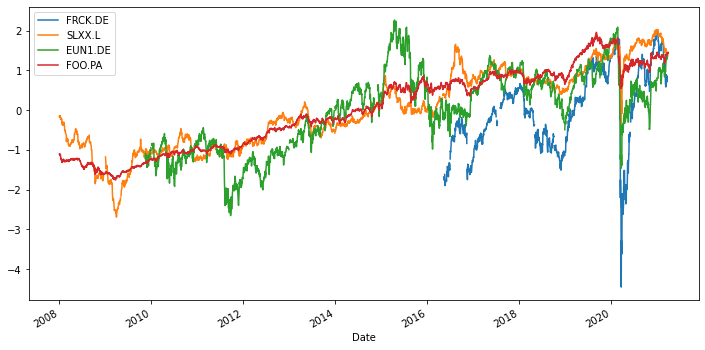

In [23]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns, index = df.index)
df.plot(figsize = (12,6))

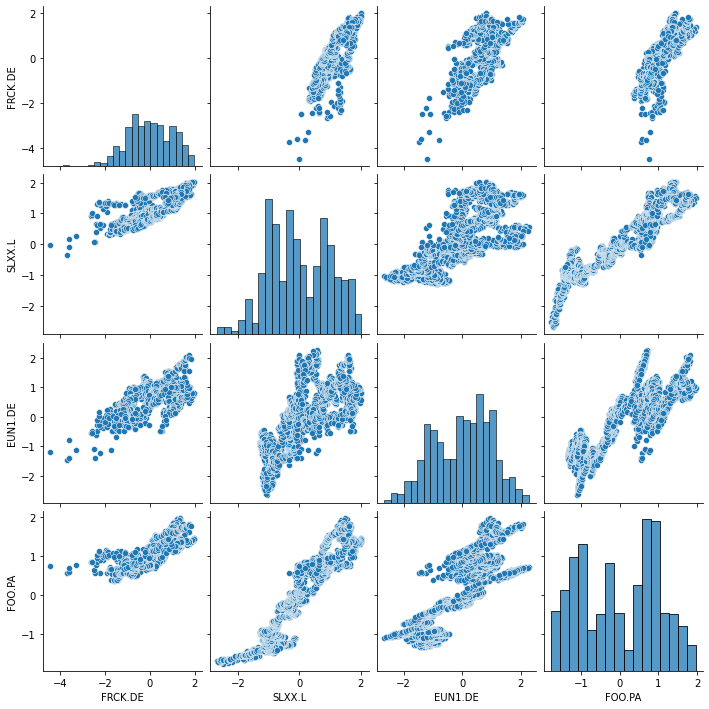

In [24]:
sns.pairplot(df)

## IS3N

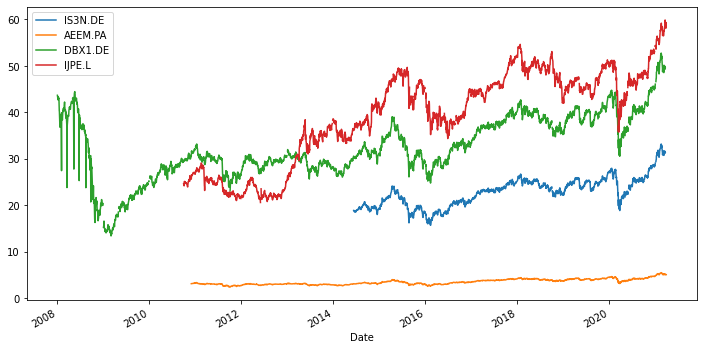

In [25]:
df = pd.DataFrame(df_finax['IS3N.DE'])
df = df.join(df_admiral[df_top['IS3N.DE']], how = 'outer')
df.plot(figsize = (12,6))

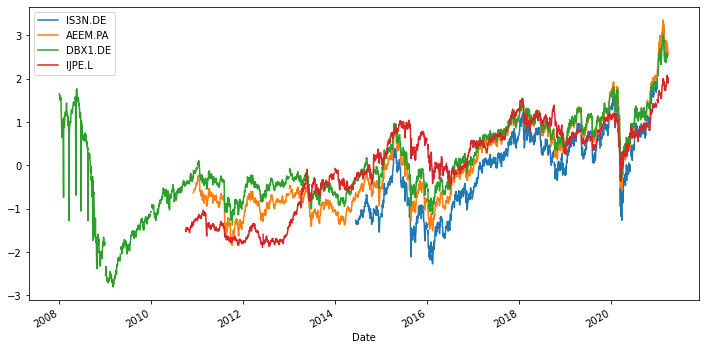

In [26]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns, index = df.index)
df.plot(figsize = (12,6))

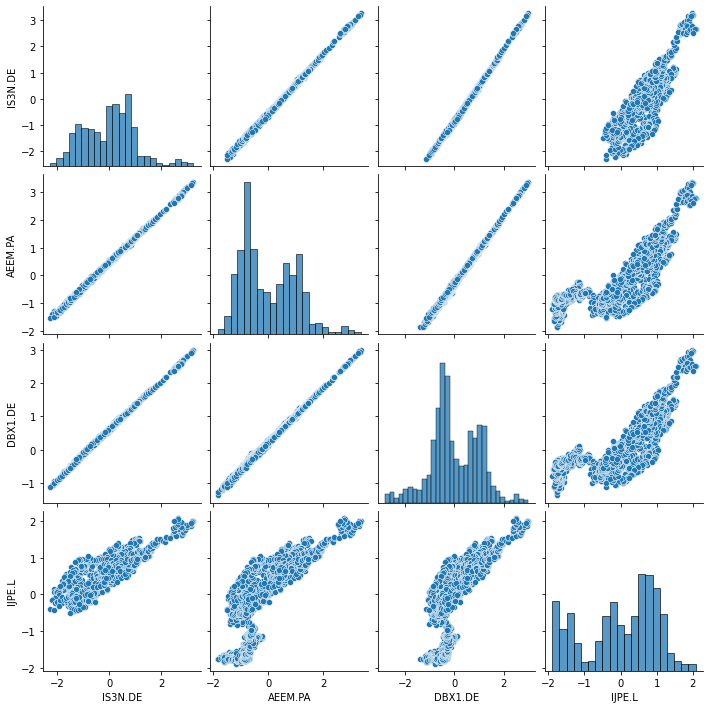

In [27]:
sns.pairplot(df)

## SPY4

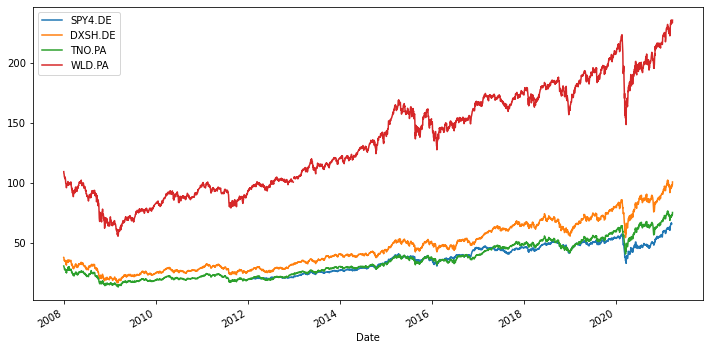

In [28]:
df = pd.DataFrame(df_finax['SPY4.DE'])
df = df.join(df_admiral[df_top['SPY4.DE']], how = 'outer')
df.plot(figsize = (12,6))

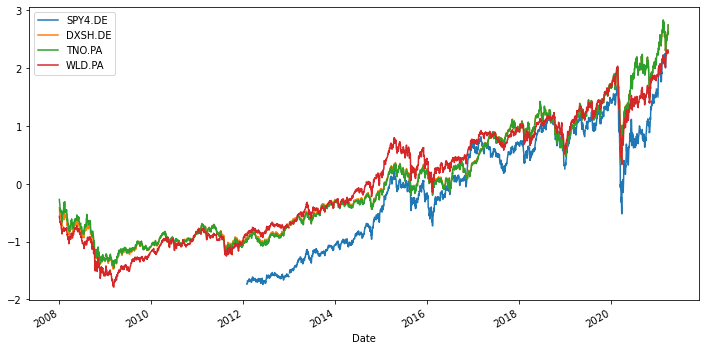

In [29]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns, index = df.index)
df.plot(figsize = (12,6))

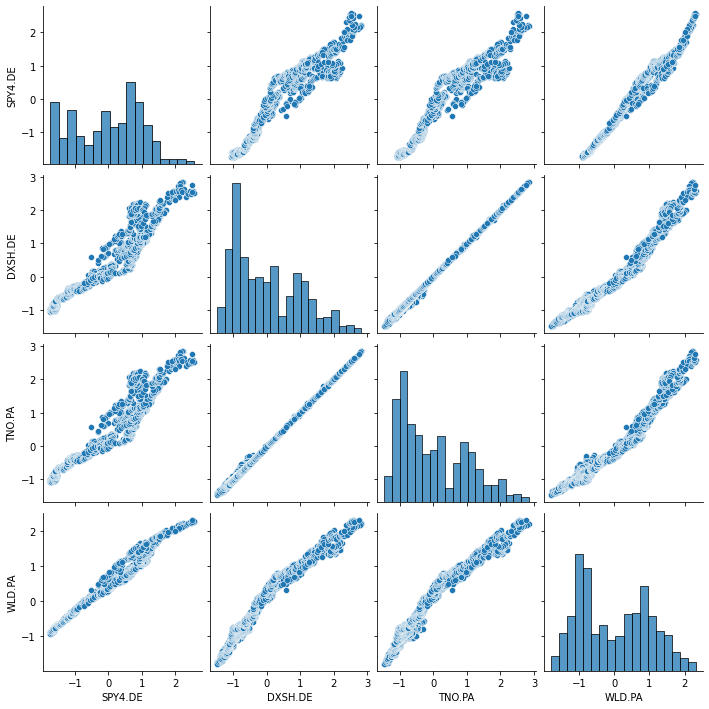

In [30]:
sns.pairplot(df)

## SXR8

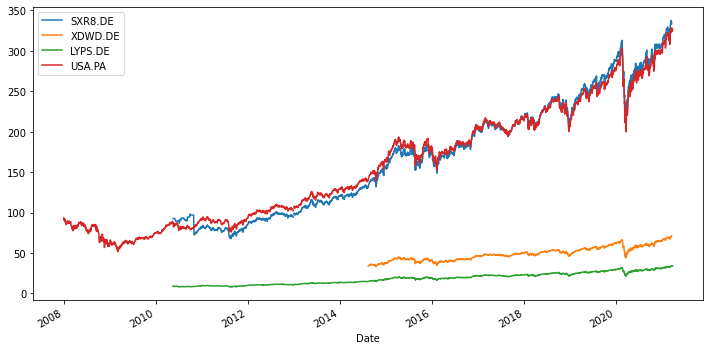

In [31]:
df = pd.DataFrame(df_finax['SXR8.DE'])
df = df.join(df_admiral[df_top['SXR8.DE']], how = 'outer')
df.plot(figsize = (12,6))

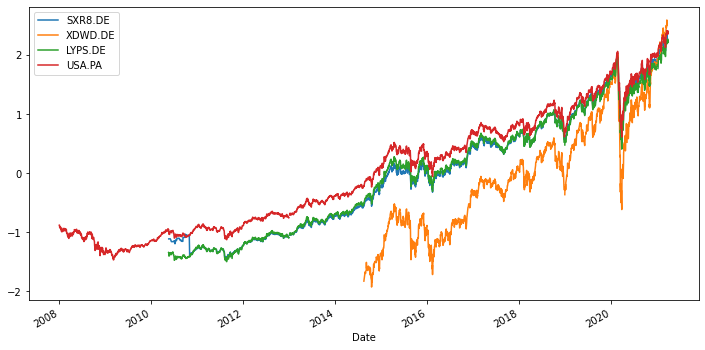

In [32]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns, index = df.index)
df.plot(figsize = (12,6))

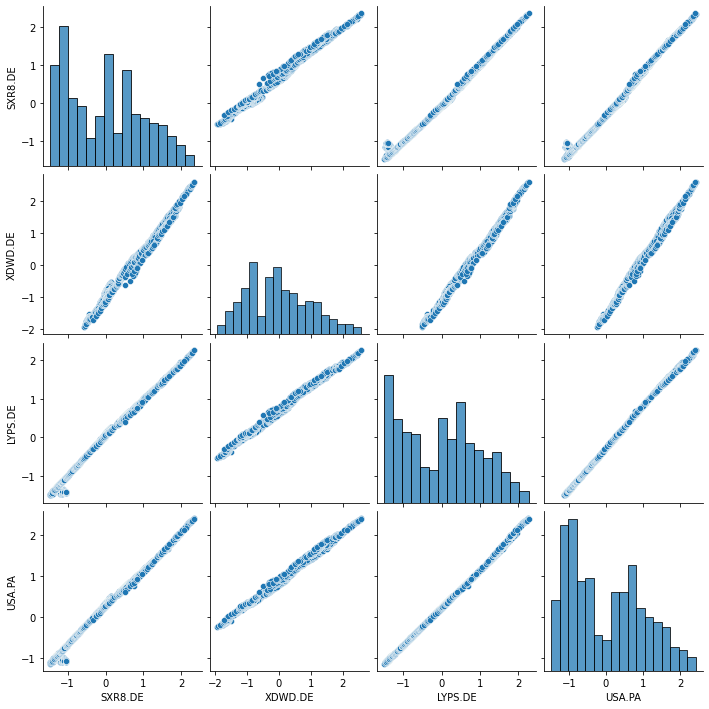

In [33]:
sns.pairplot(df)

## XBLC

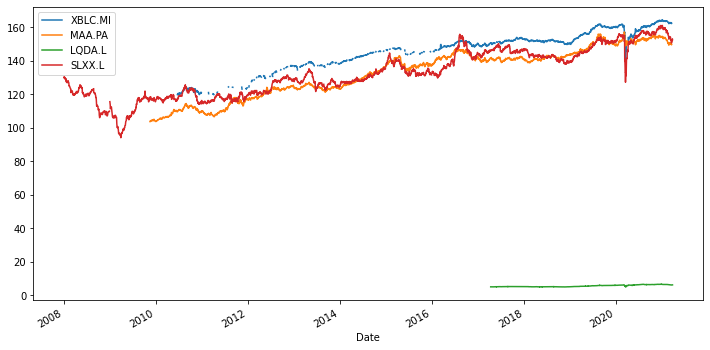

In [34]:
df = pd.DataFrame(df_finax['XBLC.MI'])
df = df.join(df_admiral[df_top['XBLC.MI']], how = 'outer')
df.plot(figsize = (12,6))

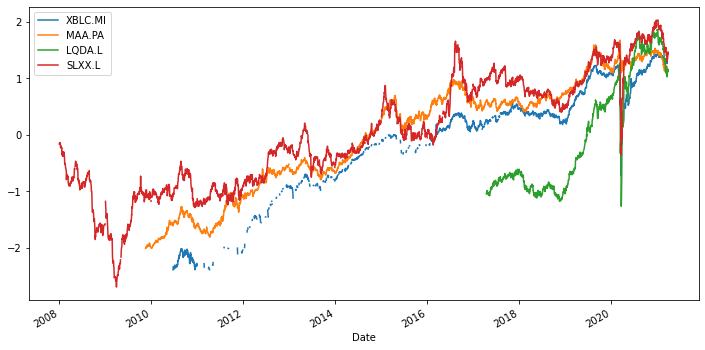

In [35]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns, index = df.index)
df.plot(figsize = (12,6))

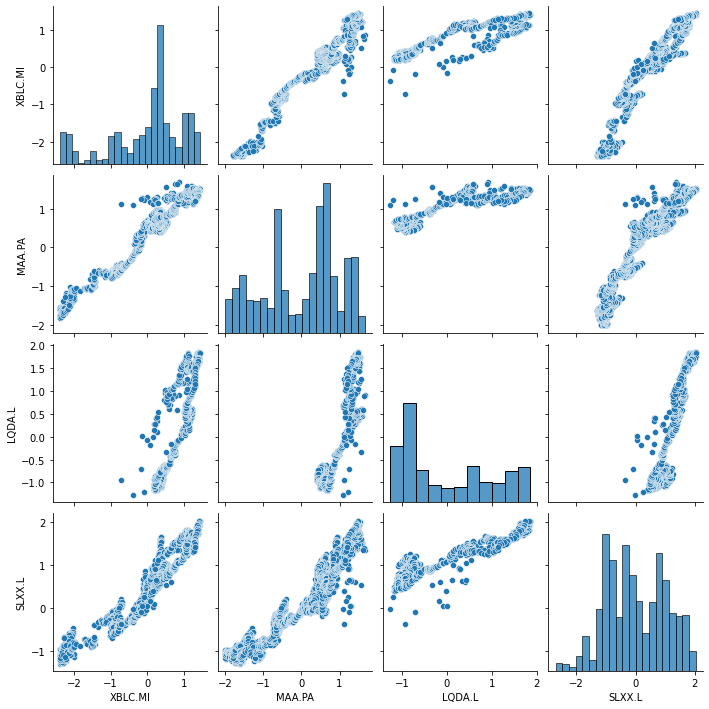

In [36]:
sns.pairplot(df)

## XHYA

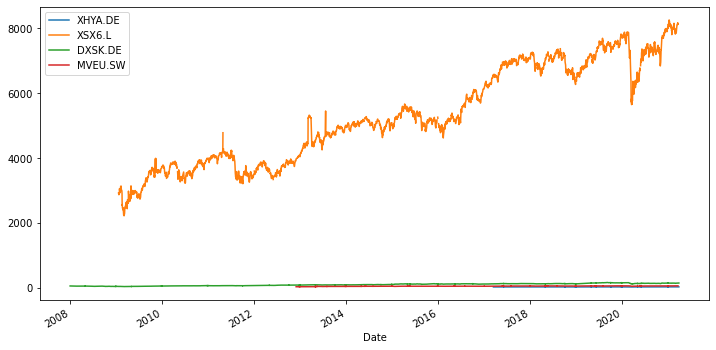

In [37]:
df = pd.DataFrame(df_finax['XHYA.DE'])
df = df.join(df_admiral[df_top['XHYA.DE']], how = 'outer')
df.plot(figsize = (12,6))

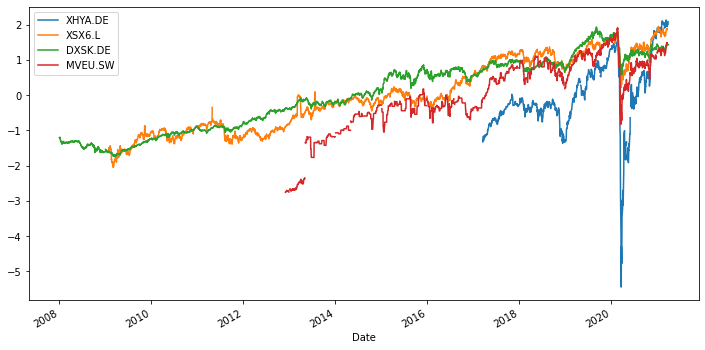

In [38]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns, index = df.index)
df.plot(figsize = (12,6))

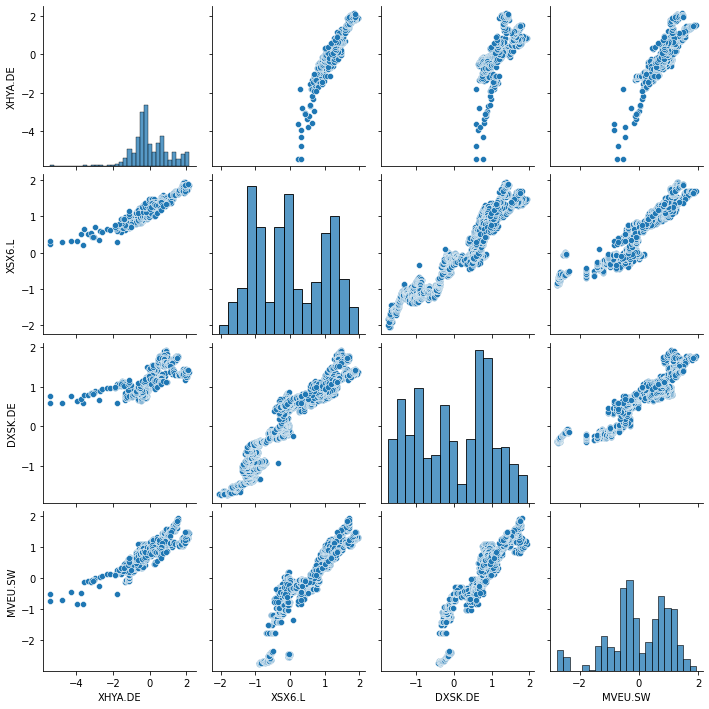

In [39]:
sns.pairplot(df)

## XSX6

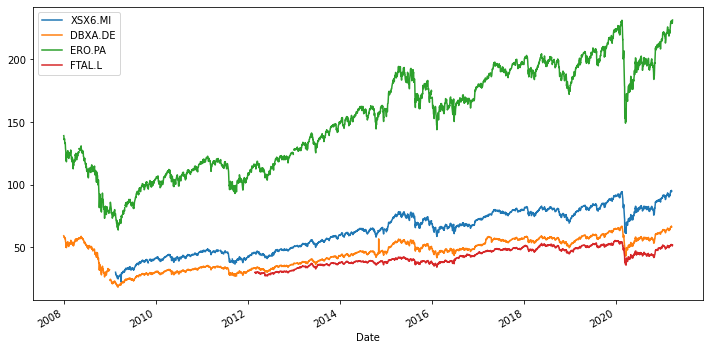

In [40]:
df = pd.DataFrame(df_finax['XSX6.MI'])
df = df.join(df_admiral[df_top['XSX6.MI']], how = 'outer')
df.plot(figsize = (12,6))

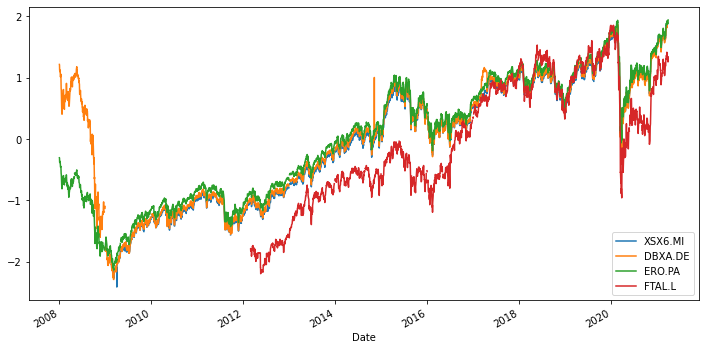

In [41]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns, index = df.index)
df.plot(figsize = (12,6))

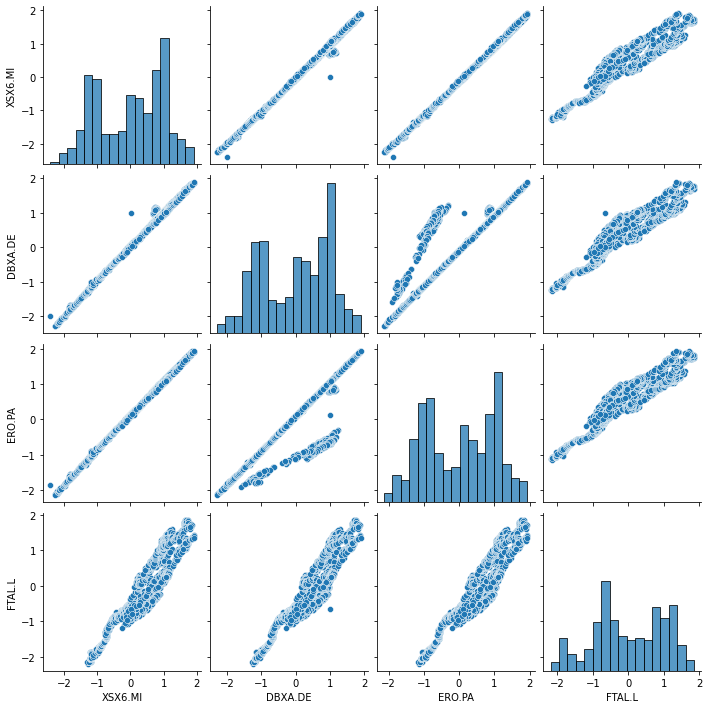

In [42]:
sns.pairplot(df)

## XXSC

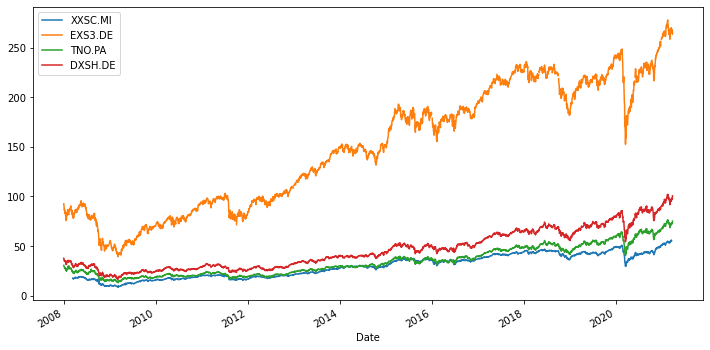

In [43]:
df = pd.DataFrame(df_finax['XXSC.MI'])
df = df.join(df_admiral[df_top['XXSC.MI']], how = 'outer')
df.plot(figsize = (12,6))

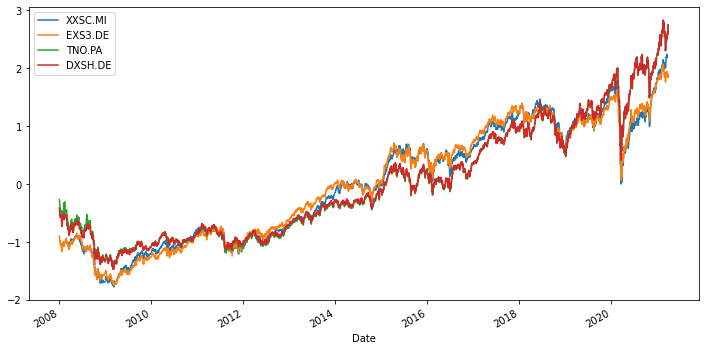

In [44]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns, index = df.index)
df.plot(figsize = (12,6))

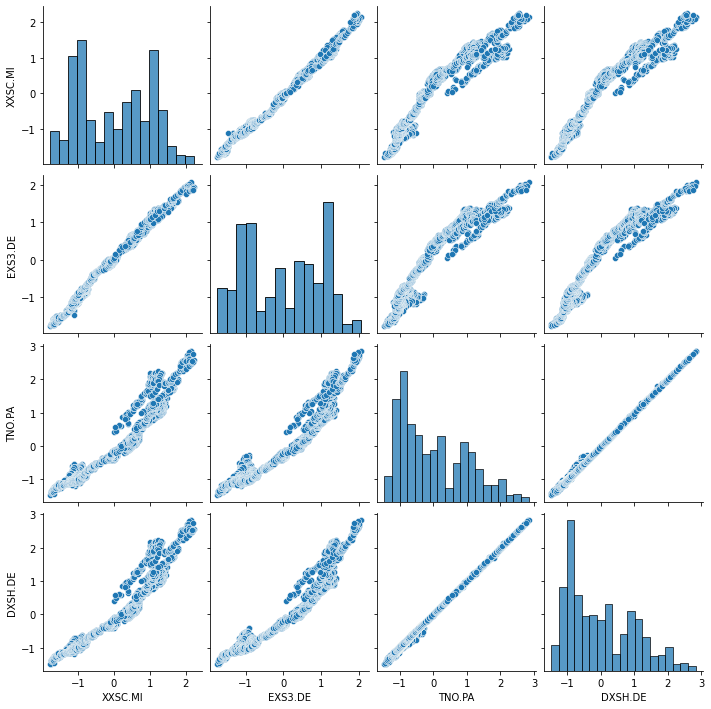

In [45]:
sns.pairplot(df)

## ZPRR

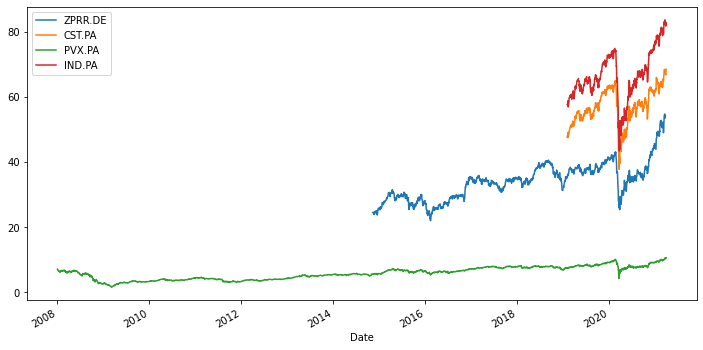

In [46]:
df = pd.DataFrame(df_finax['ZPRR.DE'])
df = df.join(df_admiral[df_top['ZPRR.DE']], how = 'outer')
df.plot(figsize = (12,6))

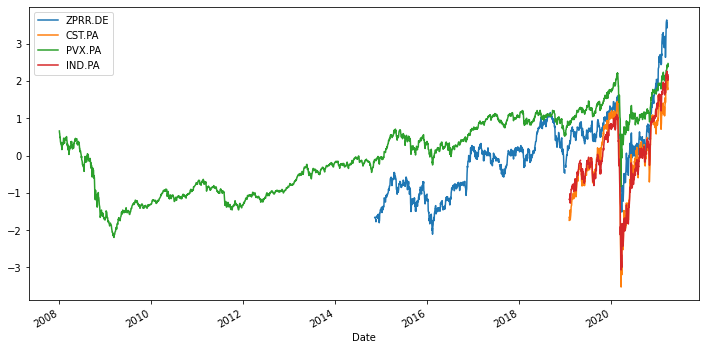

In [47]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns, index = df.index)
df.plot(figsize = (12,6))

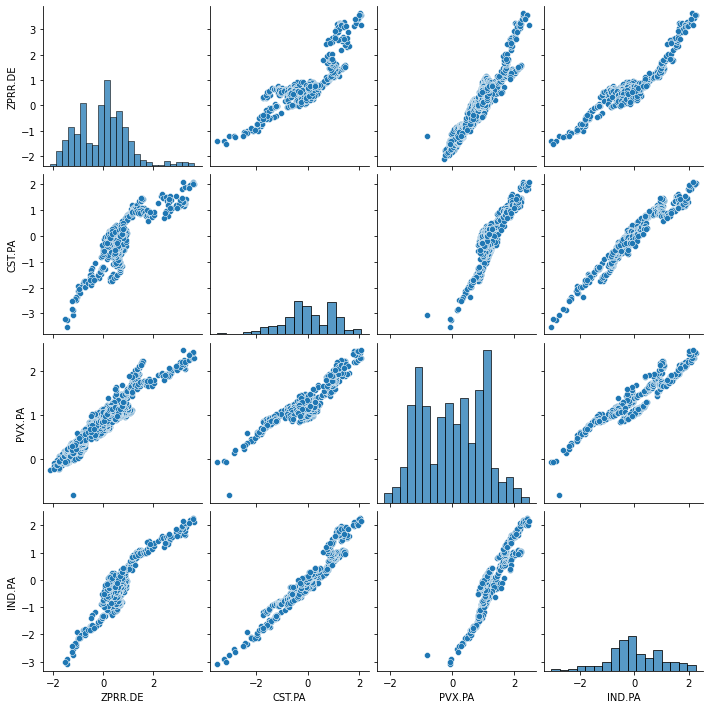

In [48]:
sns.pairplot(df)